# Análisis exploratorio de datos con todos los dataframes combinados

En esta libreta combinaremos los dataframes del proyecto para realizar un EDA (Exploratory data analysis) y poder encontrar patrones entre las variables agrícolas, económicas y climáticas con respecto a los cultivos en México.

### Librerías

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

### Combinación de los dataframes

Empezaremos por el dataframe del SIAP.

In [106]:
directory = '../limpieza'

df_SIAP = pd.read_csv(os.path.join(directory,"SIAP.csv"))
df_SIAP.head()

,Año,Mes,Cultivo,Estado,Distrito,Municipio,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha)
0,2020,1,Tomate rojo,Aguascalientes,Aguascalientes,Calvillo,16.0,6.0,0.0,90.00,15.00
1,2020,1,Tomate rojo,Baja California,Ensenada,Ensenada,19.5,0.0,0.0,0.00,0.00
2,2020,1,Tomate rojo,Baja California Sur,Mulegé,Mulegé,80.0,0.0,0.0,0.00,0.00
3,2020,1,Tomate rojo,Baja California Sur,Comondú,Comondú,127.0,0.0,0.0,0.00,0.00
4,2020,1,Tomate rojo,Baja California Sur,La Paz,La Paz,611.0,106.0,0.0,4429.76,41.79


En algunos dataframes posteriores a combinar, solo se tienen instancias desglosadas por estado y no por municipio. Por lo tanto, agruparemos por estado y haremos una suma de los valores numéricos, con excepción del rendimiento. Esto se debe a que el SIAP lo calcula dividiendo las columnas 'Producción' y 'Superficie(ha)_Cosechada'. Después de realizar la agrupación, calcularemos el rendimiento. Algunos registros del rendimiento darán NaN, ya que hay registros con 0 producción y 0 cosecha, simplemente los convertimos a *0* numérico.

In [107]:
df_SIAP_state = df_SIAP.groupby(['Año', 'Mes', 'Cultivo', 'Estado']).agg({
    'Superficie(ha)_Sembrada': 'sum',
    'Superficie(ha)_Cosechada': 'sum',
    'Superficie(ha)_Siniestrada': 'sum',
    'Producción': 'sum',
}).reset_index()

# Calculo de 'Rendimiento(udm/ha)' y convertimos los registros NaN a 0
df_SIAP_state['Rendimiento(udm/ha)'] = df_SIAP_state['Producción'] / df_SIAP_state['Superficie(ha)_Cosechada']
df_SIAP_state['Rendimiento(udm/ha)'] = df_SIAP_state['Rendimiento(udm/ha)'].fillna(0)

In [108]:
df_SIAP_state.head(10)

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha)
0,2020,1,Berenjena,Baja California Sur,11.00,0.00,0.0,0.00,0.000000
1,2020,1,Berenjena,Morelos,0.40,0.00,0.0,0.00,0.000000
2,2020,1,Berenjena,Nayarit,60.00,0.00,0.0,0.00,0.000000
3,2020,1,Berenjena,Quintana Roo,12.50,10.00,0.0,49.00,4.900000
4,2020,1,Berenjena,Sinaloa,1313.50,1073.23,0.0,50629.27,47.174669
5,2020,1,Berenjena,Sonora,76.00,0.00,0.0,0.00,0.000000
6,2020,1,Berenjena,Yucatán,28.46,0.00,0.0,0.00,0.000000
7,2020,1,Brócoli,Aguascalientes,440.00,0.00,0.0,0.00,0.000000
8,2020,1,Brócoli,Baja California,886.46,815.81,0.0,12273.01,15.043956
9,2020,1,Brócoli,Baja California Sur,1.90,0.00,0.0,0.00,0.000000


In [112]:
df_SIAP_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28282 entries, 0 to 28281
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Año                         28282 non-null  int64  
 1   Mes                         28282 non-null  int64  
 2   Cultivo                     28282 non-null  object 
 3   Estado                      28282 non-null  object 
 4   Superficie(ha)_Sembrada     28282 non-null  float64
 5   Superficie(ha)_Cosechada    28282 non-null  float64
 6   Superficie(ha)_Siniestrada  28282 non-null  float64
 7   Producción                  28282 non-null  float64
 8   Rendimiento(udm/ha)         28282 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 1.9+ MB


In [110]:
columns_to_update = ['Superficie(ha)_Sembrada', 'Superficie(ha)_Cosechada',
					'Superficie(ha)_Siniestrada', 'Producción']
                    
for year in list(df_SIAP_state['Año'].unique()):

    for month in range(12,1,-1):
        
        for state in list(df_SIAP_state['Estado'].unique()):

            for crop in list(df_SIAP_state['Cultivo'].unique()):

                try:
                
                    actual_month = (df_SIAP_state['Año'] == year) & (df_SIAP_state['Mes'] == month) & \
                                   (df_SIAP_state['Estado'] == state) &  (df_SIAP_state['Cultivo'] == crop)
                    previous_month = (df_SIAP_state['Año'] == year) & (df_SIAP_state['Mes'] == month-1) & \
                                     (df_SIAP_state['Estado'] == state) & (df_SIAP_state['Cultivo'] == crop)

                    if(all(df_SIAP_state.loc[actual_month, columns_to_update].values[0] - \
                        df_SIAP_state.loc[previous_month, columns_to_update].values[0] >= 0)):

                        df_SIAP_state.loc[actual_month, columns_to_update] -= \
                        df_SIAP_state.loc[previous_month, columns_to_update].values[0]
                        
                        # df_SIAP_state.loc[actual_month, 'Rendimiento(udm/ha)'] = \
                        # df_SIAP_state.loc[actual_month, 'Producción'] / \
                        # df_SIAP_state.loc[actual_month, 'Superficie(ha)_Cosechada']

                except Exception as e:
                    # print(e)
                    continue

Ahora combinaremos los datos del SIAP con los del SNIIM haciendo un `inner join`. Esto con el objetivo de unificar la información que ya tenemos sobre producción agrícola del SIAP para ahora tener también los precios a la venta por cultivo.

In [30]:
directory = '../limpieza'

df_sniim = pd.read_csv(os.path.join(directory,"df_sniim.csv"))

df_sniim.head()

,Año,Mes,Estado,Cultivo,Precio
0,2020,1,Aguascalientes,Berenjena,19.681818
1,2020,1,Aguascalientes,Brócoli,12.181818
2,2020,1,Aguascalientes,Calabacita,11.393182
3,2020,1,Aguascalientes,Cebolla,6.795455
4,2020,1,Aguascalientes,Chile verde,15.309659


In [31]:
df_sniim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31288 entries, 0 to 31287
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Año      31288 non-null  int64  
 1   Mes      31288 non-null  int64  
 2   Estado   31288 non-null  object 
 3   Cultivo  31288 non-null  object 
 4   Precio   31288 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ MB


In [32]:
df_SIAP_sniim = pd.merge(
    df_SIAP_state,
    df_sniim,
    how="inner",
    on=["Año", "Mes", "Cultivo", "Estado"],
)

df_SIAP_sniim.head()

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio
0,2020,1,Berenjena,Nayarit,60.00,0.00,0.0,0.00,0.000000,26.545455
1,2020,1,Berenjena,Yucatán,28.46,0.00,0.0,0.00,0.000000,5.830000
2,2020,1,Brócoli,Aguascalientes,440.00,0.00,0.0,0.00,0.000000,12.181818
3,2020,1,Brócoli,Baja California,886.46,815.81,0.0,12273.01,15.043956,26.710000
4,2020,1,Brócoli,Baja California Sur,1.90,0.00,0.0,0.00,0.000000,26.000000


In [33]:
df_SIAP_sniim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19171 entries, 0 to 19170
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Año                         19171 non-null  int64  
 1   Mes                         19171 non-null  int64  
 2   Cultivo                     19171 non-null  object 
 3   Estado                      19171 non-null  object 
 4   Superficie(ha)_Sembrada     19171 non-null  float64
 5   Superficie(ha)_Cosechada    19171 non-null  float64
 6   Superficie(ha)_Siniestrada  19171 non-null  float64
 7   Producción                  19171 non-null  float64
 8   Rendimiento(udm/ha)         19171 non-null  float64
 9   Precio                      19171 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 1.5+ MB


Después agregaremos datos meteorológicos por estado con un `left join`, donde, desde ahora en adelenta, el dataframe de la izquierda será el combiando de los datos del SIAP y SNIIM.

In [34]:
directory = '../limpieza'

df_clima = pd.read_csv(os.path.join(directory,"Data_Climatic_Estatal_Inferido_Clean.csv"))

df_clima.head()

,Año,Mes,Estado,Estado_CVE,Temp_Superficial,Temp_Superficial_MAX,Temp_Superficial_MIN,Temp_2_Metros,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion
0,2020,1,Aguascalientes,1,11.871672,24.617947,3.252815,11.622434,19.955865,4.849208,2.336100,6.980059,79.269296,2.306334,59.219238,0.836100
1,2020,1,Baja California,2,11.503548,21.848387,5.296516,12.156581,19.138839,7.561161,3.232000,7.694516,96.414323,2.328968,60.059871,0.225097
2,2020,1,Baja California Sur,3,18.086452,27.860968,12.222968,17.575806,24.043097,13.045290,10.594581,14.085290,99.619742,2.680968,67.542323,0.050258
3,2020,1,Campeche,4,24.531466,30.339472,20.069032,24.493050,30.125425,19.977243,18.949589,21.721496,100.730762,0.696833,73.750880,1.040616
4,2020,1,Chiapas,7,20.458480,27.968901,15.246714,20.349943,26.273483,15.924568,16.362354,18.356055,91.695314,1.527048,80.520960,1.351758


In [35]:
df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Año                            1472 non-null   int64  
 1   Mes                            1472 non-null   int64  
 2   Estado                         1472 non-null   object 
 3   Estado_CVE                     1472 non-null   int64  
 4   Temp_Superficial               1472 non-null   float64
 5   Temp_Superficial_MAX           1472 non-null   float64
 6   Temp_Superficial_MIN           1472 non-null   float64
 7   Temp_2_Metros                  1472 non-null   float64
 8   Temp_2_Metros_MAX              1472 non-null   float64
 9   Temp_2_Metros_MIN              1472 non-null   float64
 10  Temp_2_Metros_Pto_Congelación  1472 non-null   float64
 11  Temp_2_Metros_Pto_Húmedo       1472 non-null   float64
 12  Presión_Superficial            1472 non-null   f

In [36]:
df_SIAP_sniim_clima = pd.merge(
    df_SIAP_sniim,
    df_clima,
    how="left",
    on=["Año", "Mes", "Estado"],
)
df_SIAP_sniim_clima.head()

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,...,Temp_Superficial_MIN,Temp_2_Metros,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion
0,2020,1,Berenjena,Nayarit,60.00,0.00,0.0,0.00,0.000000,26.545455,...,13.741581,19.796194,26.256194,14.834145,11.615113,15.705790,92.821242,1.488903,63.214177,2.056097
1,2020,1,Berenjena,Yucatán,28.46,0.00,0.0,0.00,0.000000,5.830000,...,20.018247,24.568564,30.368262,19.961978,18.301996,21.435265,101.449988,0.637279,70.907876,0.629178
2,2020,1,Brócoli,Aguascalientes,440.00,0.00,0.0,0.00,0.000000,12.181818,...,3.252815,11.622434,19.955865,4.849208,2.336100,6.980059,79.269296,2.306334,59.219238,0.836100
3,2020,1,Brócoli,Baja California,886.46,815.81,0.0,12273.01,15.043956,26.710000,...,5.296516,12.156581,19.138839,7.561161,3.232000,7.694516,96.414323,2.328968,60.059871,0.225097
4,2020,1,Brócoli,Baja California Sur,1.90,0.00,0.0,0.00,0.000000,26.000000,...,12.222968,17.575806,24.043097,13.045290,10.594581,14.085290,99.619742,2.680968,67.542323,0.050258


In [37]:
df_SIAP_sniim_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19171 entries, 0 to 19170
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Año                            19171 non-null  int64  
 1   Mes                            19171 non-null  int64  
 2   Cultivo                        19171 non-null  object 
 3   Estado                         19171 non-null  object 
 4   Superficie(ha)_Sembrada        19171 non-null  float64
 5   Superficie(ha)_Cosechada       19171 non-null  float64
 6   Superficie(ha)_Siniestrada     19171 non-null  float64
 7   Producción                     19171 non-null  float64
 8   Rendimiento(udm/ha)            19171 non-null  float64
 9   Precio                         19171 non-null  float64
 10  Estado_CVE                     19171 non-null  int64  
 11  Temp_Superficial               19171 non-null  float64
 12  Temp_Superficial_MAX           19171 non-null 

Incluiremos la precipitación mensual a nivel estatal, también con un `left join`.

In [47]:
directory = '../limpieza'

df_precipitation = pd.read_csv(os.path.join(directory,"precip.csv"))

df_precipitation = df_precipitation.rename(
                    columns={'Precipitacion': 'Precipitación'})


df_precipitation.head()

,Estado,Año,Mes,Precipitación
0,Aguascalientes,2015,1,7.1
1,Baja California,2015,1,21.7
2,Baja California Sur,2015,1,26.0
3,Campeche,2015,1,90.1
4,Coahuila,2015,1,26.4


In [48]:
df_precipitation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3072 entries, 0 to 3071
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Estado         3072 non-null   object 
 1   Año            3072 non-null   int64  
 2   Mes            3072 non-null   int64  
 3   Precipitación  3072 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 96.1+ KB


In [49]:
df_SIAP_sniim_clima_precip = pd.merge(
    df_SIAP_sniim_clima,
    df_precipitation,
    how="left",
    on=["Año", "Mes", "Estado"],
)
df_SIAP_sniim_clima_precip.head()

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,...,Temp_2_Metros,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion,Precipitación
0,2020,1,Berenjena,Nayarit,60.00,0.00,0.0,0.00,0.000000,26.545455,...,19.796194,26.256194,14.834145,11.615113,15.705790,92.821242,1.488903,63.214177,2.056097,60.4
1,2020,1,Berenjena,Yucatán,28.46,0.00,0.0,0.00,0.000000,5.830000,...,24.568564,30.368262,19.961978,18.301996,21.435265,101.449988,0.637279,70.907876,0.629178,29.5
2,2020,1,Brócoli,Aguascalientes,440.00,0.00,0.0,0.00,0.000000,12.181818,...,11.622434,19.955865,4.849208,2.336100,6.980059,79.269296,2.306334,59.219238,0.836100,38.5
3,2020,1,Brócoli,Baja California,886.46,815.81,0.0,12273.01,15.043956,26.710000,...,12.156581,19.138839,7.561161,3.232000,7.694516,96.414323,2.328968,60.059871,0.225097,4.3
4,2020,1,Brócoli,Baja California Sur,1.90,0.00,0.0,0.00,0.000000,26.000000,...,17.575806,24.043097,13.045290,10.594581,14.085290,99.619742,2.680968,67.542323,0.050258,1.9


In [50]:
df_SIAP_sniim_clima_precip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19171 entries, 0 to 19170
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Año                            19171 non-null  int64  
 1   Mes                            19171 non-null  int64  
 2   Cultivo                        19171 non-null  object 
 3   Estado                         19171 non-null  object 
 4   Superficie(ha)_Sembrada        19171 non-null  float64
 5   Superficie(ha)_Cosechada       19171 non-null  float64
 6   Superficie(ha)_Siniestrada     19171 non-null  float64
 7   Producción                     19171 non-null  float64
 8   Rendimiento(udm/ha)            19171 non-null  float64
 9   Precio                         19171 non-null  float64
 10  Estado_CVE                     19171 non-null  int64  
 11  Temp_Superficial               19171 non-null  float64
 12  Temp_Superficial_MAX           19171 non-null 

Por último, el índice de volumen físico, el cual nos dice cuanto cultivo hubo de acuerdo al año anterior. De igual forma, lo agregaremos con un `left join`.

In [51]:
directory = '../limpieza'

df_ivf = pd.read_csv(os.path.join(directory,"ivf.csv"))

df_ivf.head()

,Cultivo,Año,Mes,Ivf
0,Berenjena,2015,12,3.88
1,Brócoli,2015,12,39.05
2,Calabacita,2015,12,109.13
3,Cebolla,2015,12,86.09
4,Chile verde,2015,12,134.97


In [54]:
df_SIAP_sniim_clima_precip_ivf = pd.merge(
    df_SIAP_sniim_clima_precip,
    df_ivf,
    how="left",
    on=["Año", "Mes", "Cultivo"],
)
df_SIAP_sniim_clima_precip_ivf.head()

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,...,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion,Precipitación,Ivf
0,2020,1,Berenjena,Nayarit,60.00,0.00,0.0,0.00,0.000000,26.545455,...,26.256194,14.834145,11.615113,15.705790,92.821242,1.488903,63.214177,2.056097,60.4,763
1,2020,1,Berenjena,Yucatán,28.46,0.00,0.0,0.00,0.000000,5.830000,...,30.368262,19.961978,18.301996,21.435265,101.449988,0.637279,70.907876,0.629178,29.5,763
2,2020,1,Brócoli,Aguascalientes,440.00,0.00,0.0,0.00,0.000000,12.181818,...,19.955865,4.849208,2.336100,6.980059,79.269296,2.306334,59.219238,0.836100,38.5,138.1
3,2020,1,Brócoli,Baja California,886.46,815.81,0.0,12273.01,15.043956,26.710000,...,19.138839,7.561161,3.232000,7.694516,96.414323,2.328968,60.059871,0.225097,4.3,138.1
4,2020,1,Brócoli,Baja California Sur,1.90,0.00,0.0,0.00,0.000000,26.000000,...,24.043097,13.045290,10.594581,14.085290,99.619742,2.680968,67.542323,0.050258,1.9,138.1


In [55]:
df_SIAP_sniim_clima_precip_ivf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19171 entries, 0 to 19170
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Año                            19171 non-null  int64  
 1   Mes                            19171 non-null  int64  
 2   Cultivo                        19171 non-null  object 
 3   Estado                         19171 non-null  object 
 4   Superficie(ha)_Sembrada        19171 non-null  float64
 5   Superficie(ha)_Cosechada       19171 non-null  float64
 6   Superficie(ha)_Siniestrada     19171 non-null  float64
 7   Producción                     19171 non-null  float64
 8   Rendimiento(udm/ha)            19171 non-null  float64
 9   Precio                         19171 non-null  float64
 10  Estado_CVE                     19171 non-null  int64  
 11  Temp_Superficial               19171 non-null  float64
 12  Temp_Superficial_MAX           19171 non-null 

Una vez unidos todos los datasets, lo guardamos en formato CSV para su posterior uso y procedemos a realizar el EDA.

In [66]:
# Guardar en formato csv
df_SIAP_sniim_clima_precip_ivf.to_csv(os.path.join(directory,"excedente_agrícola.csv"))

### EDA con YData Profiling (JANNETH)

### Detectando datos faltantes (JANNETH)

### Detectando anomalías (JANNETH)

### Analizando relación entre variables por visualización (AXEL)

### Analizando correlación entre variables (KEVIN)

### Usando PCA (VICTOR)

Para finalizar, aplicaremos un análisis por componentes principales (PCA).

Varianza explicada acumulada:
[0.29198023 0.43933648 0.5231933  0.59181063 0.64297747 0.68877159
 0.72947969 0.76952671 0.80856178 0.84463736 0.87750611 0.90842975
 0.93654611 0.96248545 0.97626491 0.98836053 0.99721399 0.99859027
 0.99917465 0.99957615 0.99980086 0.99992178 0.99999077 1.
 1.        ]


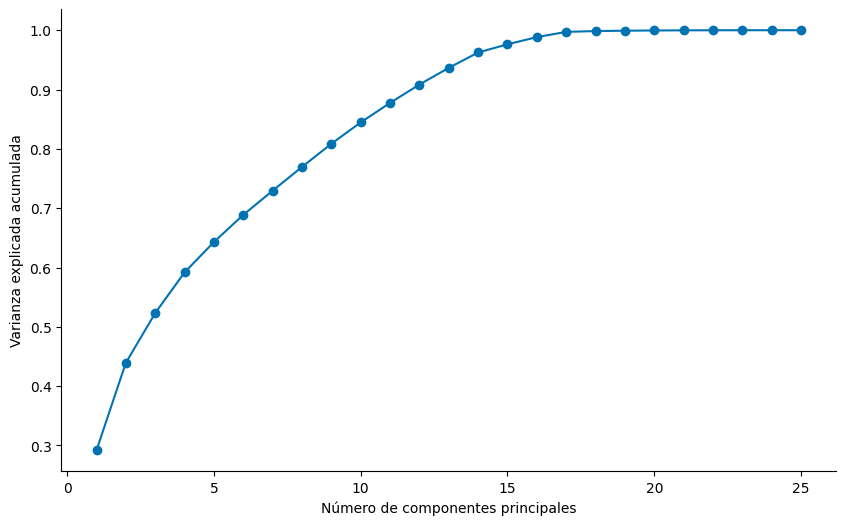

In [3]:
# Seleccionamos columnas numéricas
columns_numeric = df_SIAP_sniim_clima_precip_ivf.select_dtypes(include='number').columns
df_to_pca = df_SIAP_sniim_clima_precip_ivf[columns_numeric].copy()

# Codificamos las variables categóricas
label_encoder = LabelEncoder()
df_to_pca['Estado'] = label_encoder.fit_transform(df_SIAP_sniim_clima_precip_ivf['Estado'])
df_to_pca['Cultivo'] = label_encoder.fit_transform(df_SIAP_sniim_clima_precip_ivf['Cultivo'])

# Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
df_to_pca = pd.DataFrame(imputer.fit_transform(df_to_pca), columns=df_to_pca.columns)

# Estandarizamos a media 0 y varianza 1
scaler = StandardScaler()
df_to_pca_scaled = scaler.fit_transform(df_to_pca)

# Aplicamos PCA
pca = PCA()
pca.fit_transform(df_to_pca_scaled)

# Obtenemos la varianza explicada acumulada
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()
print("Varianza explicada acumulada:")
print(cumulative_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(False)
plt.show()

Con 2 componentes principales solo explicamos el 43% de los datos, es un porcentaje bajo y al explorar solo usando estos componentes no se obtiene información relevante como se puede ver en la siguiente celda.

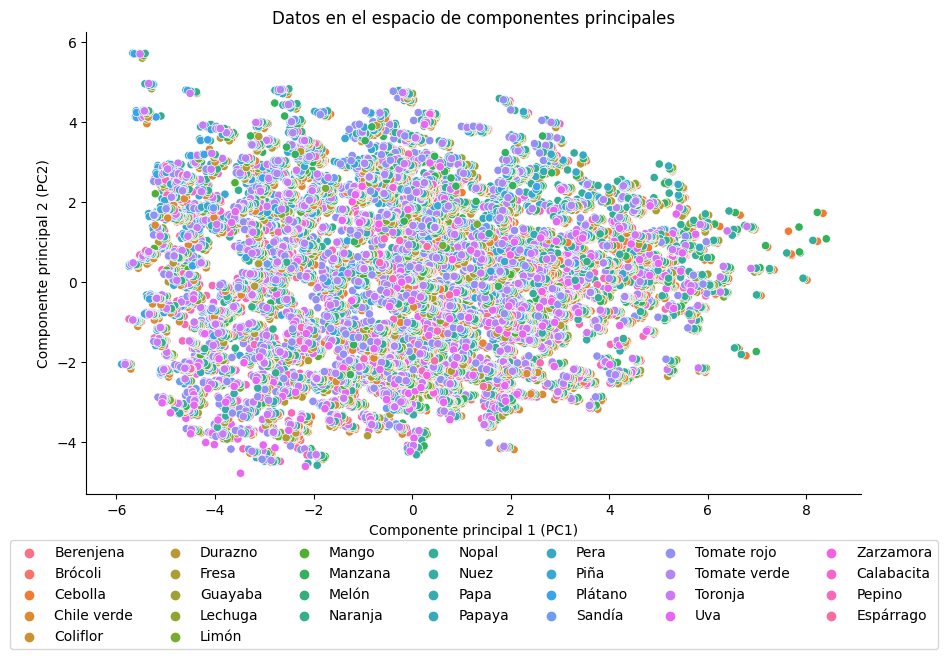

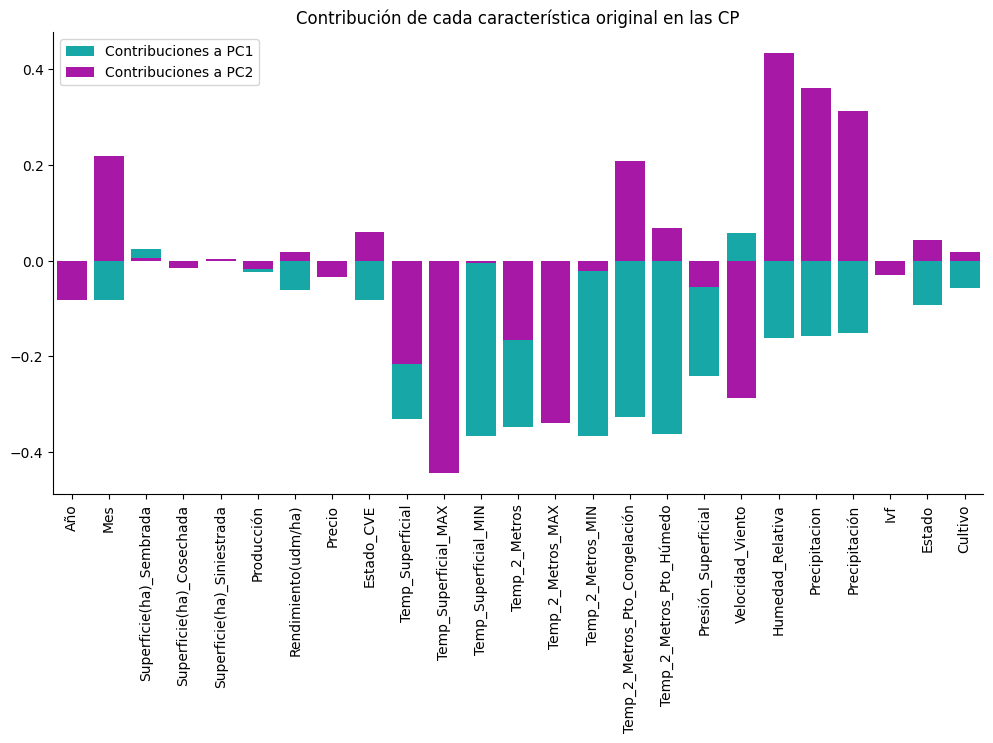


Contribuyentes de PC1:
Temp_Superficial_MIN        0.366771
Temp_2_Metros_MIN           0.366714
Temp_2_Metros_Pto_Húmedo    0.362602
Name: PC1, dtype: float64

Contribuyentes de PC2:
Temp_Superficial_MAX    0.444551
Humedad_Relativa        0.433394
Precipitacion           0.360582
Name: PC2, dtype: float64


In [228]:
# Aplicamos PCA
pca2 = PCA(n_components=2)
x_pca2 = pca2.fit_transform(df_to_pca_scaled)

# Creamos un dataframe con las componentes principales
df_pca2 = pd.DataFrame(x_pca2, columns=['PC1', 'PC2'])

# Graficamos el espacio de componentes principales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=df_pca2, hue=df_SIAP_sniim_clima_precip_ivf['Cultivo'])
plt.title('Datos en el espacio de componentes principales')
plt.xlabel('Componente principal 1 (PC1)')
plt.ylabel('Componente principal 2 (PC2)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=7)

plt.show()

# Analizamos la contribución de cada característica original en las 
# componentes principales
loadings_df2 = pd.DataFrame(pca2.components_.T, columns=['PC1', 'PC2'], index=df_to_pca.columns)

plt.figure(figsize=(12, 6))
sns.barplot(x=loadings_df2.index, y='PC1', data=loadings_df2, color='c', label='Contribuciones a PC1')
sns.barplot(x=loadings_df2.index, y='PC2', data=loadings_df2, color='m', label='Contribuciones a PC2')
plt.title('Contribución de cada característica original en las CP')
plt.ylabel('')
plt.xticks(rotation=90)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend()
plt.show()

# Principales contribuyentes en las componentes principales
loadings_df_abs_sorted_pc1 = loadings_df2['PC1'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc2 = loadings_df2['PC2'].abs().sort_values(ascending=False)

print("\nContribuyentes de PC1:")
print(loadings_df_abs_sorted_pc1[:3])

print("\nContribuyentes de PC2:")
print(loadings_df_abs_sorted_pc2[:3])


Por otro lado, encontramos que con 5 componentes principales ya existe un componente principal que relacione el precio con el cultivo y el rendimiento, que es algo de interés para el cliente. Además, estos 5 explican el 64% de la varianza.

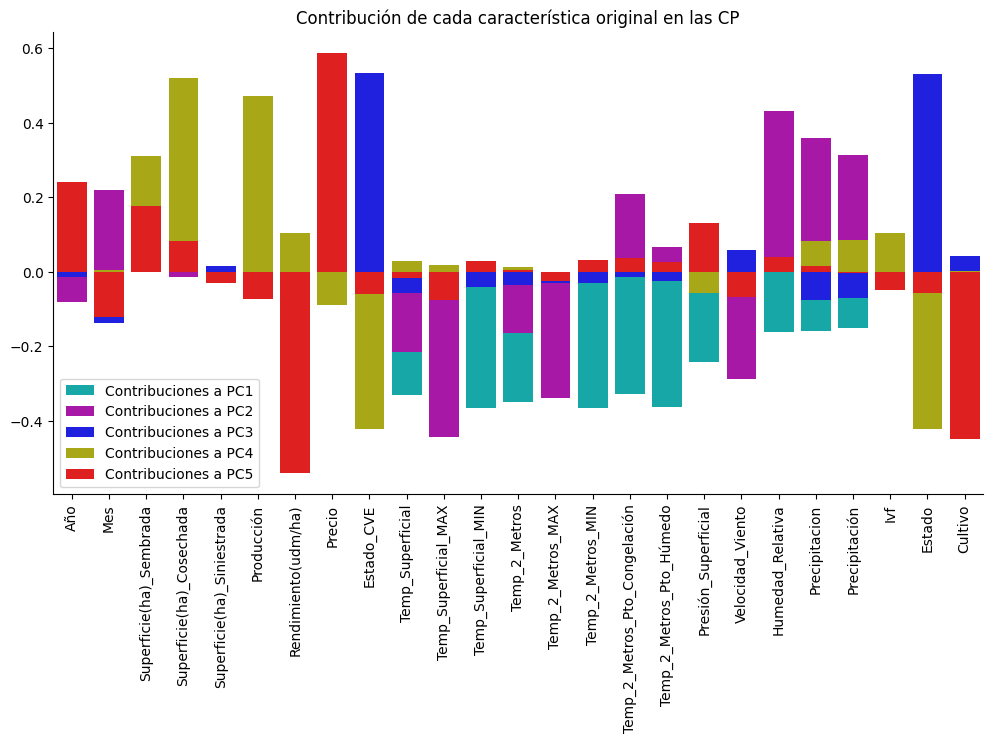


Contribuyentes de PC1:
Temp_Superficial_MIN        0.366771
Temp_2_Metros_MIN           0.366714
Temp_2_Metros_Pto_Húmedo    0.362602
Name: PC1, dtype: float64

Contribuyentes de PC2:
Temp_Superficial_MAX    0.444551
Humedad_Relativa        0.433395
Precipitacion           0.360582
Name: PC2, dtype: float64

Contribuyentes de PC3:
Estado_CVE                  0.533679
Estado                      0.531863
Superficie(ha)_Cosechada    0.395835
Name: PC3, dtype: float64

Contribuyentes de PC4:
Superficie(ha)_Cosechada    0.521396
Producción                  0.473647
Estado                      0.422702
Name: PC4, dtype: float64

Contribuyentes de PC5:
Precio                 0.586755
Rendimiento(udm/ha)    0.541069
Cultivo                0.449019
Name: PC5, dtype: float64


In [230]:
# Aplicamos PCA
pca5 = PCA(n_components=5)
x_pca5 = pca5.fit_transform(df_to_pca_scaled)

# Creamos un dataframe con las componentes principales
loadings_df5 = pd.DataFrame(pca5.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=df_to_pca.columns)

# Analizamos la contribución de cada característica original en las 
# componentes principales
plt.figure(figsize=(12, 6))
sns.barplot(x=loadings_df5.index, y='PC1', data=loadings_df5, color='c', label='Contribuciones a PC1')
sns.barplot(x=loadings_df5.index, y='PC2', data=loadings_df5, color='m', label='Contribuciones a PC2')
sns.barplot(x=loadings_df5.index, y='PC3', data=loadings_df5, color='b', label='Contribuciones a PC3')
sns.barplot(x=loadings_df5.index, y='PC4', data=loadings_df5, color='y', label='Contribuciones a PC4')
sns.barplot(x=loadings_df5.index, y='PC5', data=loadings_df5, color='r', label='Contribuciones a PC5')
plt.title('Contribución de cada característica original en las CP')
plt.ylabel('')
plt.xticks(rotation=90)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend()
plt.show()

# Principales contribuyentes en las componentes principales
loadings_df_abs_sorted_pc1 = loadings_df5['PC1'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc2 = loadings_df5['PC2'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc3 = loadings_df5['PC3'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc4 = loadings_df5['PC4'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc5 = loadings_df5['PC5'].abs().sort_values(ascending=False)

print("\nContribuyentes de PC1:")
print(loadings_df_abs_sorted_pc1[:3])

print("\nContribuyentes de PC2:")
print(loadings_df_abs_sorted_pc2[:3])

print("\nContribuyentes de PC3:")
print(loadings_df_abs_sorted_pc3[:3])

print("\nContribuyentes de PC4:")
print(loadings_df_abs_sorted_pc4[:3])

print("\nContribuyentes de PC5:")
print(loadings_df_abs_sorted_pc5[:3])